### <b>IMPORTING  LIBRARIES</b>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms

import os
from tqdm import tqdm
from PIL import Image
import albumentations as A
from sklearn.model_selection import train_test_split

In [2]:
DEVICE = 'cuda:0'
EPOCHS = 40
BATCH_SIZE = 16
LR = 0.001
RATIO = 0.5 

### <b>DATA LOADER CLASS</b>

In [3]:
class LoadData(Dataset):
    def __init__(self, train = True):
        super().__init__()
        
        x = sorted(os.listdir('../input/satellite-images-of-water-bodies/Water Bodies Dataset/Images'))
        y = sorted(os.listdir('../input/satellite-images-of-water-bodies/Water Bodies Dataset/Masks'))
        
        self.image_path = []
        self.mask_path = []
        
        for i in range(len(x)):
            x[i] = '../input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/' + x[i]
            y[i] = '../input/satellite-images-of-water-bodies/Water Bodies Dataset/Masks/' + y[i]
            
        collect = list(zip(x, y))
        train_col, val_col = train_test_split(collect, shuffle = True, test_size=0.1, random_state=42)
                   
        if train:
            self.image_path = [x[0] for x in train_col]
            self.mask_path = [x[1] for x in train_col]
        else:
            self.image_path = [y[0] for y in val_col]
            self.mask_path = [y[1] for y in val_col]
        
        self.transform = A.Compose([
            A.Resize(256, 256),
            A.HorizontalFlip(),
            A.RandomBrightnessContrast(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        ])
                   
            
    def __getitem__(self, idx):
        img = Image.open(self.image_path[idx])
        mask = Image.open(self.mask_path[idx]).convert('L')
                   
        img = np.array(img)
        mask = np.array(mask)
                   
        transformer = self.transform(image = img, mask = mask)
        img = transformer['image']
        mask = transformer['mask']
                   
        img = (np.transpose(img, (2, 0, 1))) / 255
        mask = (np.expand_dims(mask, axis = 0)) / 255
                   
        img = torch.tensor(img)
        mask = torch.tensor(mask)
                
        return img, mask    
    
    
    def __len__(self):
        return len(self.image_path)

In [4]:
train_dataset = LoadData()
valid_dataset = LoadData(train = False)

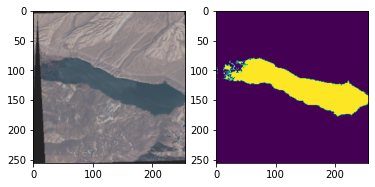

In [5]:
img, mask = train_dataset[101]

f, axarr = plt.subplots(1,2) 
axarr[1].imshow(np.squeeze(mask.numpy()))
axarr[0].imshow(np.transpose(img.numpy(), [1,2,0]))

In [6]:
train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers = 2,
)

valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers = 2,
)


# <b>UNet Model</b>

In [7]:
class DoubleConvolution(nn.Module):
    def __init__(self, in_channels : int, out_channels : int):
        super().__init__()
        
        self.first = nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1)
        self.second = nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1)
        self.act = nn.ReLU()
        
    def forward(self, x : torch.Tensor):
        x = self.first(x)
        x = self.act(x)
        x = self.second(x)
        x = self.act(x)
        
        return x

In [8]:
class DownSample(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        
    def forward(self, x : torch.Tensor):
        x = self.pool(x)
        return x

In [9]:
class UpSample(nn.Module):
    def __init__(self, in_channels : int, out_channels : int):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 2, stride = 2)
        
    def forward(self, x : torch.Tensor): 
        x = self.up(x)
        return x

In [10]:
class CropAndConcat(nn.Module):
    def forward(self, x, contract_x):
        x = torch.cat([x, contract_x], dim = 1)
        return x

In [11]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.down_conv = nn.ModuleList([DoubleConvolution(i, o) for i, o in [(in_channels, 64), (64, 128), (128, 256), (256, 512)]])
        self.down_sample = DownSample()
        self.middle_conv = DoubleConvolution(512, 1024)
        self.up_sample = nn.ModuleList([UpSample(i, o) for i, o in [(1024, 512), (512, 256), (256, 128), (128, 64)]])
        self.up_conv = nn.ModuleList([DoubleConvolution(i, o) for i, o in [(1024, 512), (512, 256), (256, 128), (128, 64)]])
        self.concat = CropAndConcat()
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size = 1)
        
    def forward(self, x):
        pass_through = []
        
        for i in range(4):
            x = self.down_conv[i](x)
            pass_through.append(x)
            x = self.down_sample(x)
            
        x = self.middle_conv(x)
        
        for i in range(4):
            x = self.up_sample[i](x)
            x = self.concat(x, pass_through.pop())
            x = self.up_conv[i](x)
            
        x = self.final_conv(x)
        return x     

In [12]:
model = UNet(in_channels = 3, out_channels = 1)
model.to(DEVICE)

UNet(
  (down_conv): ModuleList(
    (0): DoubleConvolution(
      (first): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (second): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): ReLU()
    )
    (1): DoubleConvolution(
      (first): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (second): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): ReLU()
    )
    (2): DoubleConvolution(
      (first): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (second): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): ReLU()
    )
    (3): DoubleConvolution(
      (first): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (second): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): ReLU()
    )
  )
  (down_sample): DownSample(
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0

### <b>FIXING OPTIMIZER AND LOSS FUNCTION</b>

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)
criterion = nn.BCEWithLogitsLoss()

### <b>TRAINING AND VALIDATION FUNCTION</b>

In [14]:
def train_fn(train_loader, model, criterion, optimizer):
    
    losses = []
    model.train()

    for (imgs, masks) in tqdm(train_loader, total=len(train_loader)):
        imgs = imgs.to(DEVICE, dtype = torch.float)
        masks = masks.to(DEVICE, dtype = torch.float)
        
        mask_preds = model(imgs)
        loss = criterion(mask_preds, masks)

        optimizer.zero_grad()       
        loss.backward()               
        optimizer.step()              

        losses.append(loss.item())
        
    return np.mean(losses)

In [15]:
def valid_fn(val_loader, model, criterion):
    
    losses = []
    model.eval()

    for (imgs, masks) in tqdm(val_loader, total=len(val_loader)):
        imgs = imgs.to(DEVICE, dtype = torch.float)
        masks = masks.to(DEVICE, dtype = torch.float)
        
        with torch.no_grad():
            mask_preds = model(imgs)
            loss = criterion(mask_preds, masks)
        
        losses.append(loss.item())
        
    return np.mean(losses)

### <b>VISUALIZING FUNCTION</b>

In [16]:
def visualize(model, val_loader):
    images, masks = next(iter(val_loader))
    mask_preds = model(images.to(DEVICE, dtype=torch.float32))
    mask_preds = torch.sigmoid(mask_preds)
    mask_preds = (mask_preds > RATIO)*1.0
    
    plt.figure(figsize=(10, 7))
    rows = 3
    columns = 5
    
    for i in range(1,6):
        image = images[i]
        mask = masks[i]
    
        plt.subplot(rows, columns, i)
        plt.imshow(np.transpose(image.numpy(), [1,2,0]))
    
        plt.subplot(rows, columns, i + 5)
        plt.imshow(np.transpose(mask.numpy(), [1,2,0]))
    
        plt.subplot(rows, columns, i + 10)
        plt.imshow(np.transpose(mask_preds.detach().cpu().numpy()[i], [1,2,0]))
        
    plt.show()

## <b>TRAINING THE MODEL</b>

----- Epoch 1 -----


100%|██████████| 18/18 [00:09<00:00,  1.91it/s]


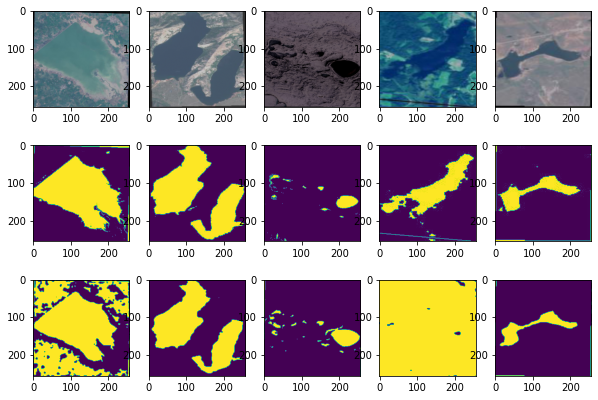

Epoch 1 - Train Loss 0.5851 - Val Loss 0.4887

----- Epoch 2 -----


100%|██████████| 18/18 [00:08<00:00,  2.07it/s]


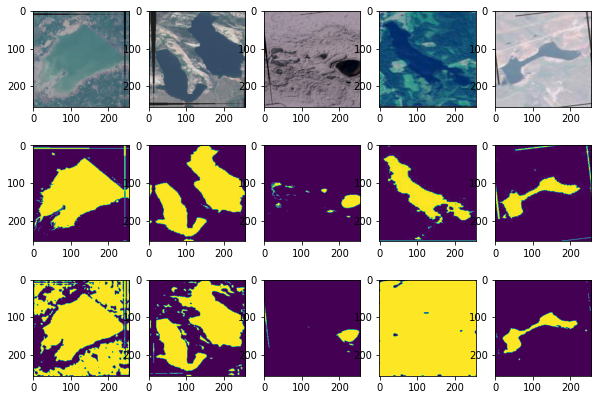

Epoch 2 - Train Loss 0.5111 - Val Loss 0.4834

----- Epoch 3 -----


100%|██████████| 18/18 [00:08<00:00,  2.16it/s]


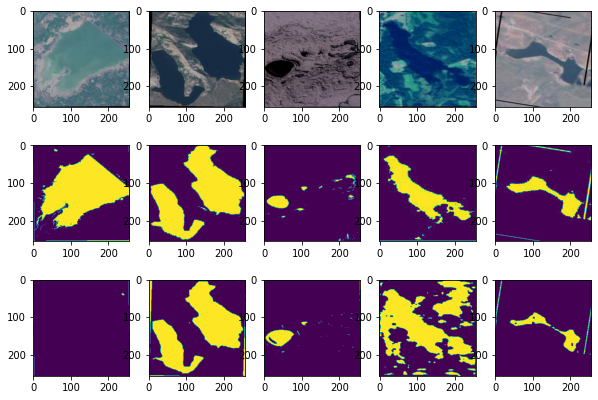

Epoch 3 - Train Loss 0.5007 - Val Loss 0.4745

----- Epoch 4 -----


100%|██████████| 18/18 [00:08<00:00,  2.10it/s]


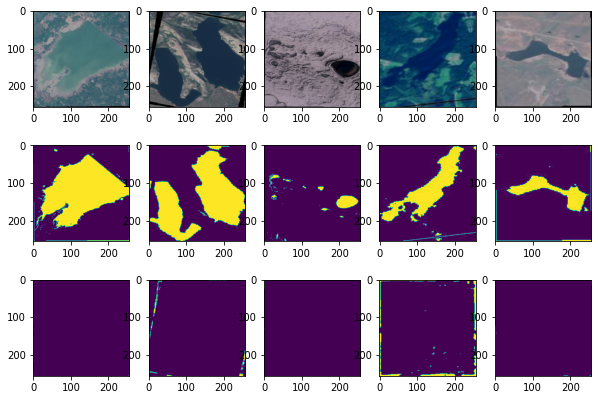

Epoch 4 - Train Loss 1.7815 - Val Loss 0.5314

----- Epoch 5 -----


100%|██████████| 18/18 [00:09<00:00,  1.95it/s]


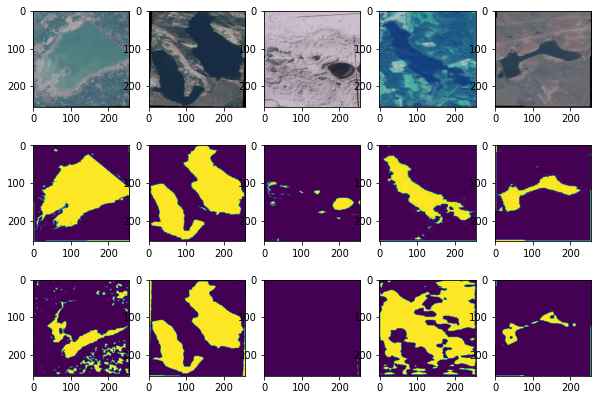

Epoch 5 - Train Loss 0.5109 - Val Loss 0.4760

----- Epoch 6 -----


100%|██████████| 18/18 [00:08<00:00,  2.03it/s]


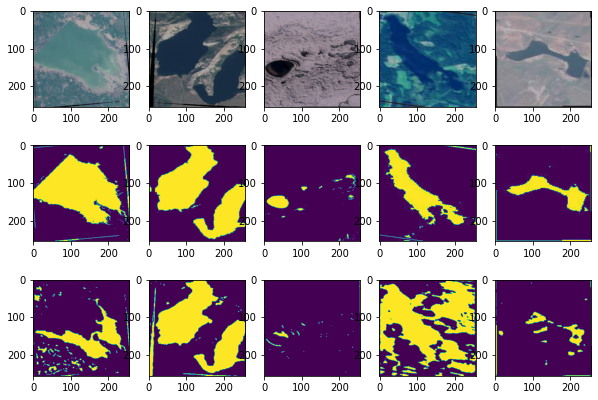

Epoch 6 - Train Loss 0.4857 - Val Loss 0.4648

----- Epoch 7 -----


100%|██████████| 18/18 [00:09<00:00,  1.98it/s]


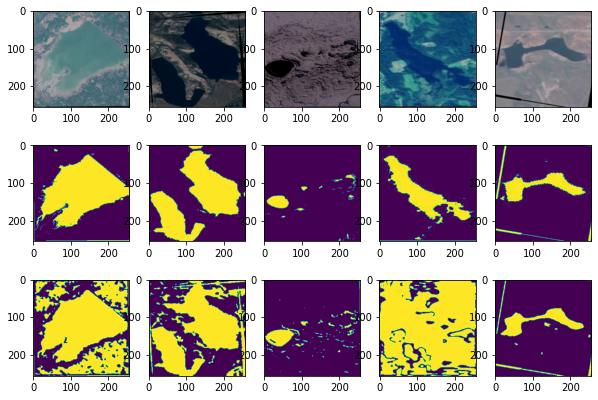

Epoch 7 - Train Loss 0.4793 - Val Loss 0.4758

----- Epoch 8 -----


100%|██████████| 18/18 [00:08<00:00,  2.00it/s]


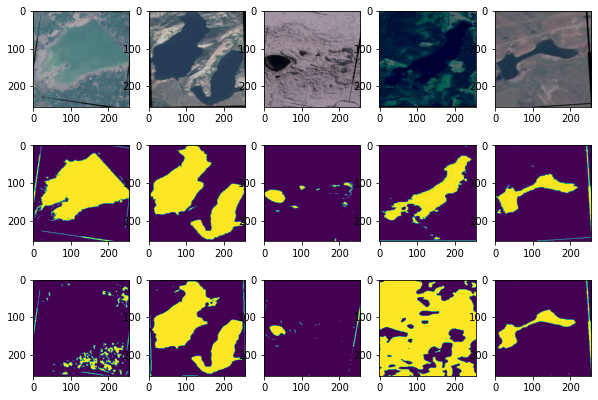

Epoch 8 - Train Loss 0.4738 - Val Loss 0.4463

----- Epoch 9 -----


100%|██████████| 18/18 [00:08<00:00,  2.10it/s]


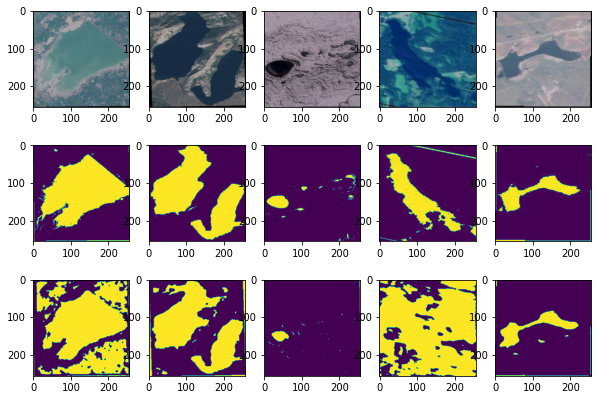

Epoch 9 - Train Loss 0.4587 - Val Loss 0.4813

----- Epoch 10 -----


100%|██████████| 18/18 [00:08<00:00,  2.19it/s]


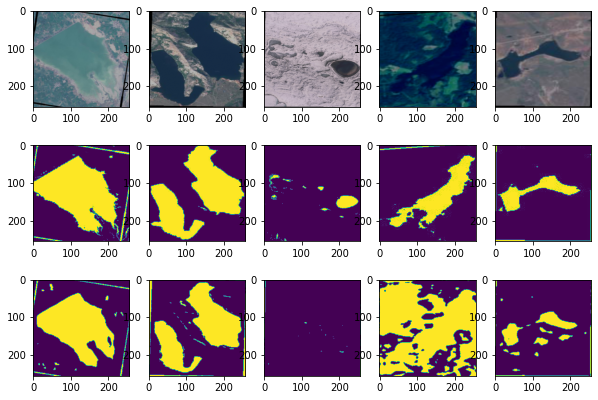

Epoch 10 - Train Loss 0.4565 - Val Loss 0.4125

----- Epoch 11 -----


100%|██████████| 18/18 [00:08<00:00,  2.17it/s]


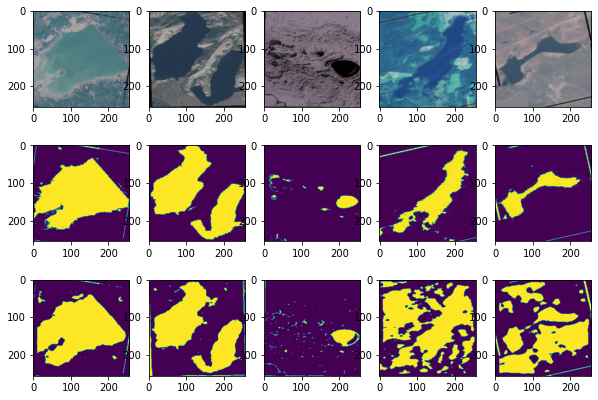

Epoch 11 - Train Loss 0.4270 - Val Loss 0.4088

----- Epoch 12 -----


100%|██████████| 18/18 [00:08<00:00,  2.15it/s]


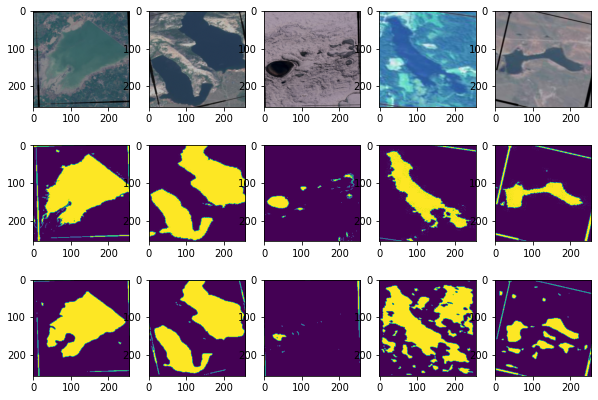

Epoch 12 - Train Loss 0.4130 - Val Loss 0.3935

----- Epoch 13 -----


100%|██████████| 18/18 [00:08<00:00,  2.15it/s]


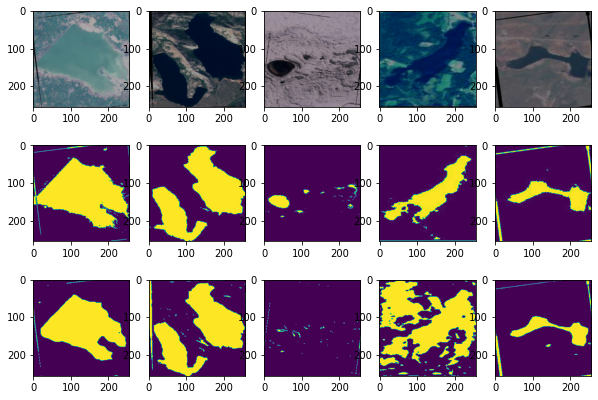

Epoch 13 - Train Loss 0.4124 - Val Loss 0.3893

----- Epoch 14 -----


100%|██████████| 18/18 [00:08<00:00,  2.23it/s]


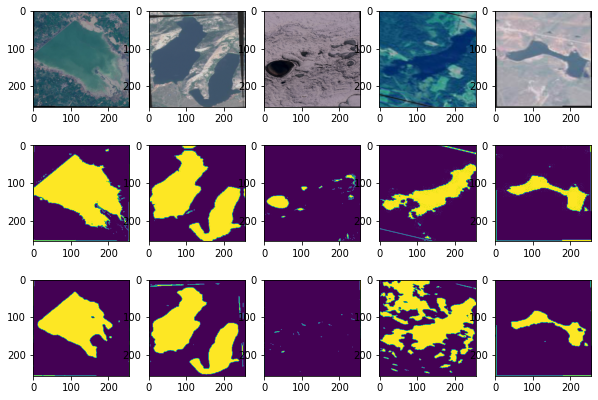

Epoch 14 - Train Loss 0.3959 - Val Loss 0.3976

----- Epoch 15 -----


100%|██████████| 18/18 [00:08<00:00,  2.12it/s]


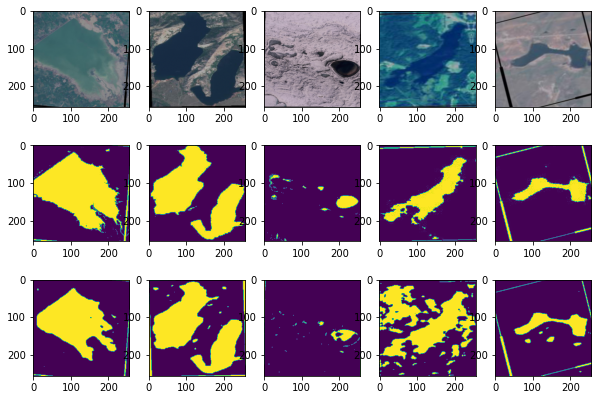

Epoch 15 - Train Loss 0.3916 - Val Loss 0.3905

----- Epoch 16 -----


100%|██████████| 18/18 [00:08<00:00,  2.19it/s]


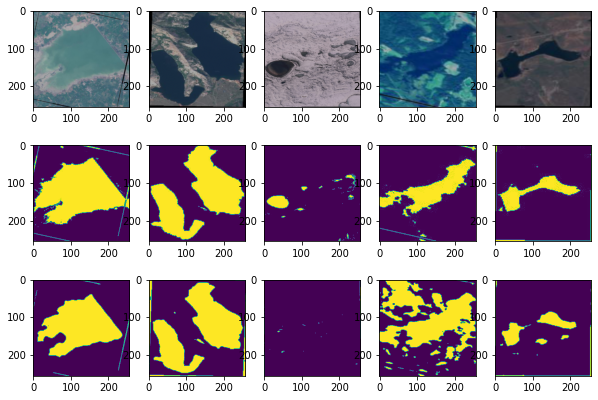

Epoch 16 - Train Loss 0.3868 - Val Loss 0.3801

----- Epoch 17 -----


100%|██████████| 18/18 [00:08<00:00,  2.21it/s]


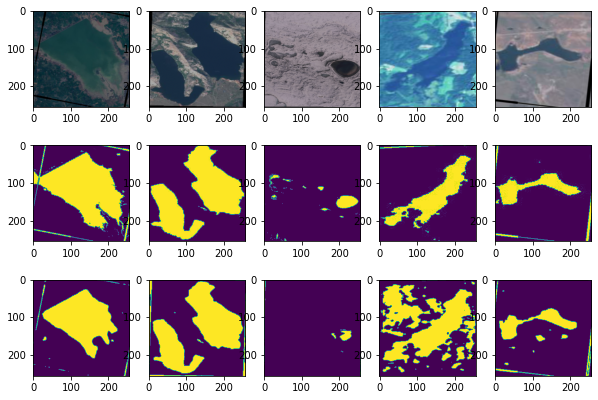

Epoch 17 - Train Loss 0.3837 - Val Loss 0.3695

----- Epoch 18 -----


100%|██████████| 18/18 [00:08<00:00,  2.17it/s]


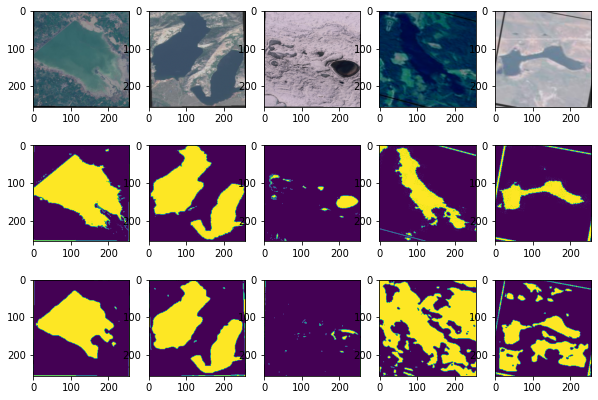

Epoch 18 - Train Loss 0.3790 - Val Loss 0.3638

----- Epoch 19 -----


100%|██████████| 18/18 [00:08<00:00,  2.15it/s]


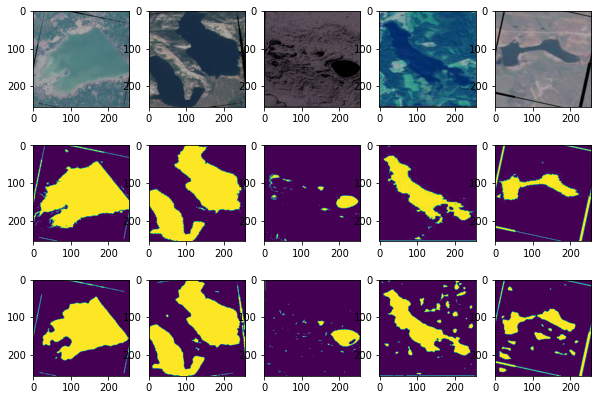

Epoch 19 - Train Loss 0.3749 - Val Loss 0.3693

----- Epoch 20 -----


100%|██████████| 18/18 [00:08<00:00,  2.01it/s]


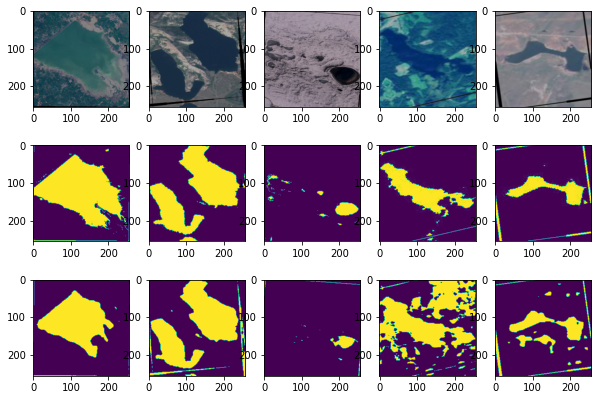

Epoch 20 - Train Loss 0.3765 - Val Loss 0.3714

----- Epoch 21 -----


100%|██████████| 18/18 [00:08<00:00,  2.06it/s]


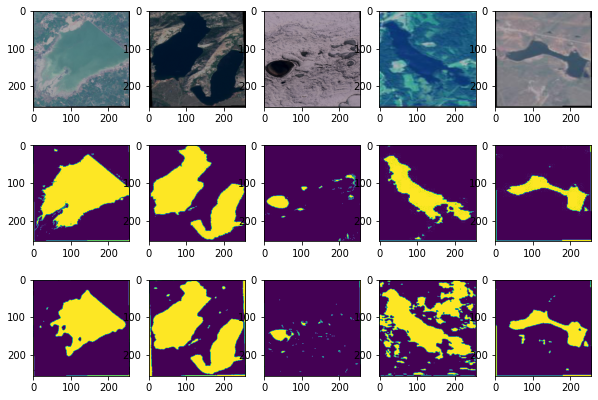

Epoch 21 - Train Loss 0.3744 - Val Loss 0.3734

----- Epoch 22 -----


100%|██████████| 18/18 [00:08<00:00,  2.01it/s]


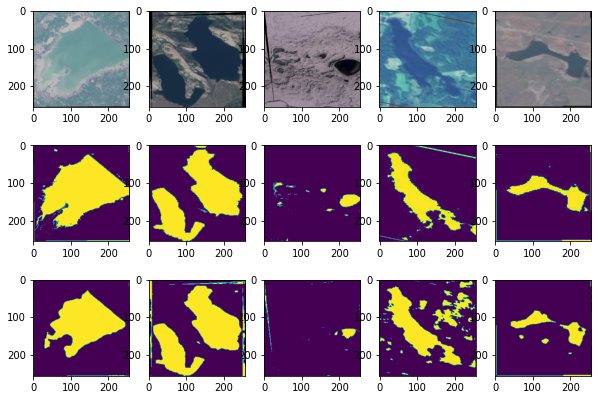

Epoch 22 - Train Loss 0.3728 - Val Loss 0.3724

----- Epoch 23 -----


100%|██████████| 18/18 [00:08<00:00,  2.10it/s]


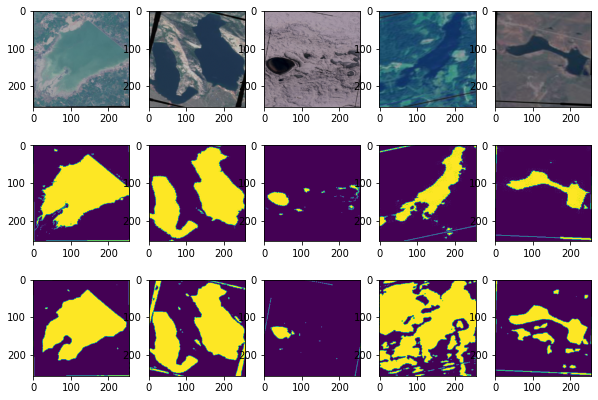

Epoch 23 - Train Loss 0.3662 - Val Loss 0.3699

----- Epoch 24 -----


100%|██████████| 18/18 [00:08<00:00,  2.21it/s]


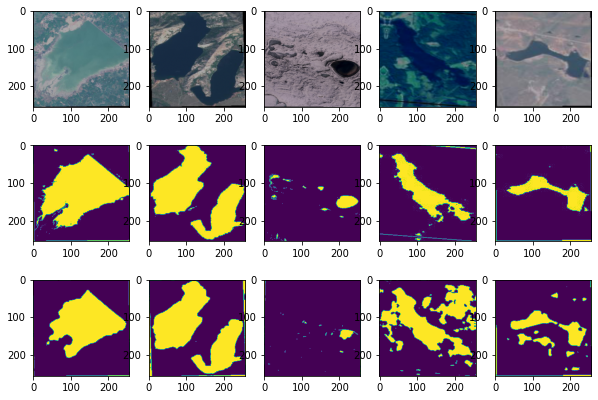

Epoch 24 - Train Loss 0.3779 - Val Loss 0.3677

----- Epoch 25 -----


100%|██████████| 18/18 [00:08<00:00,  2.17it/s]


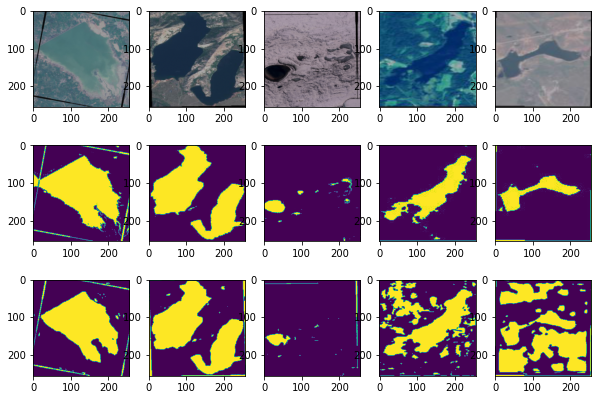

Epoch 25 - Train Loss 0.3733 - Val Loss 0.3671

----- Epoch 26 -----


100%|██████████| 18/18 [00:08<00:00,  2.08it/s]


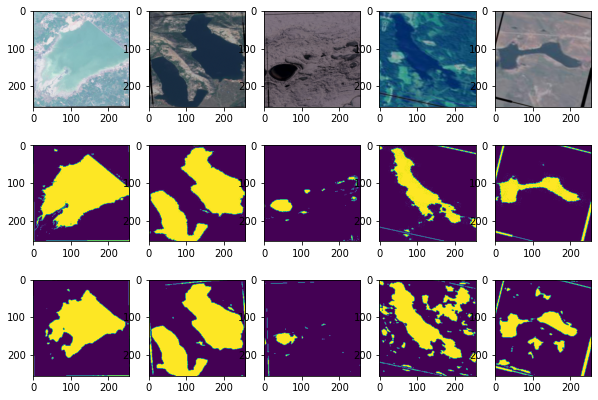

Epoch 26 - Train Loss 0.3679 - Val Loss 0.3720

----- Epoch 27 -----


100%|██████████| 18/18 [00:08<00:00,  2.18it/s]


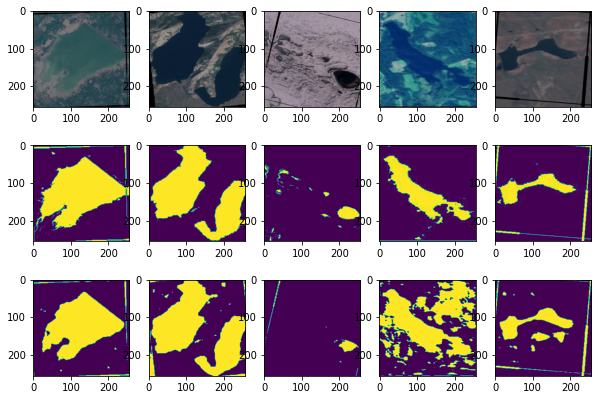

Epoch 27 - Train Loss 0.3705 - Val Loss 0.3508

----- Epoch 28 -----


100%|██████████| 18/18 [00:08<00:00,  2.03it/s]


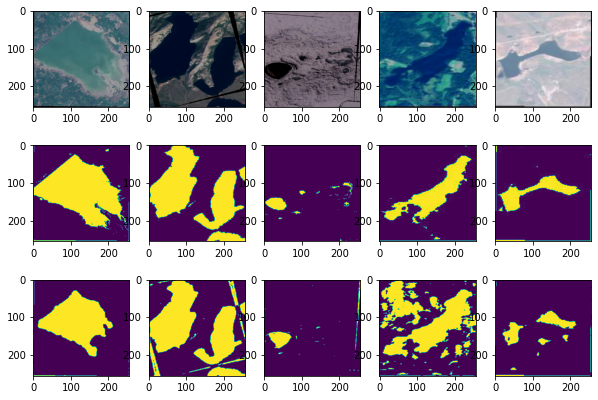

Epoch 28 - Train Loss 0.3638 - Val Loss 0.3750

----- Epoch 29 -----


100%|██████████| 18/18 [00:08<00:00,  2.09it/s]


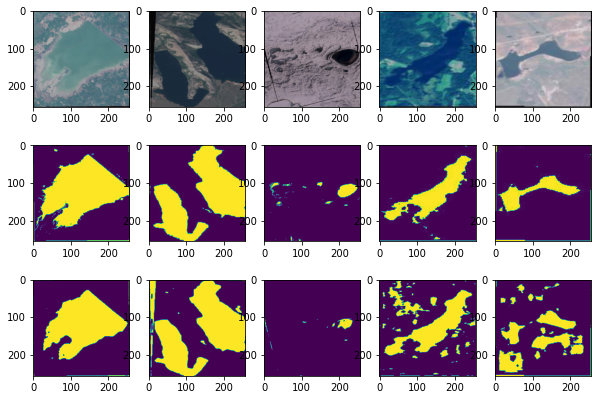

Epoch 29 - Train Loss 0.3600 - Val Loss 0.3528

----- Epoch 30 -----


100%|██████████| 18/18 [00:08<00:00,  2.08it/s]


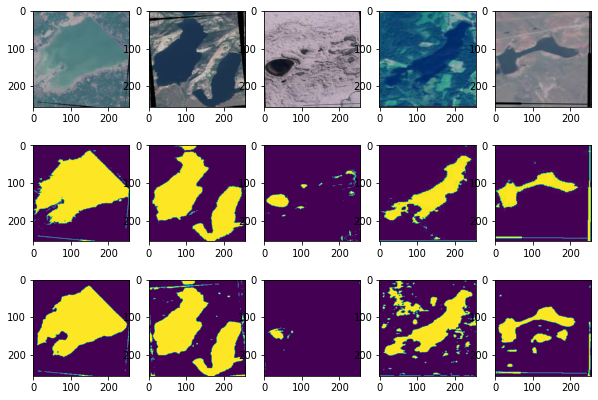

Epoch 30 - Train Loss 0.3587 - Val Loss 0.3443

----- Epoch 31 -----


100%|██████████| 18/18 [00:08<00:00,  2.10it/s]


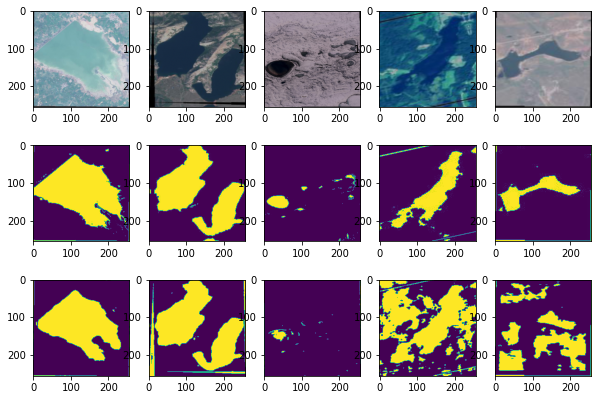

Epoch 31 - Train Loss 0.3611 - Val Loss 0.3454

----- Epoch 32 -----


100%|██████████| 18/18 [00:08<00:00,  2.12it/s]


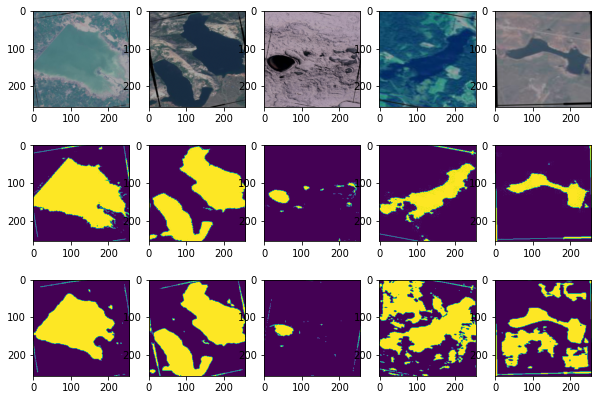

Epoch 32 - Train Loss 0.3592 - Val Loss 0.3541

----- Epoch 33 -----


100%|██████████| 18/18 [00:08<00:00,  2.12it/s]


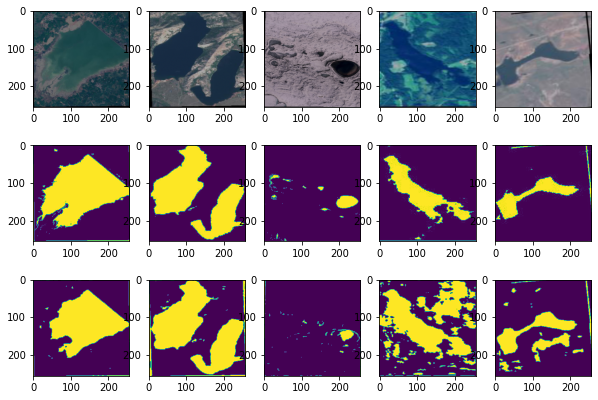

Epoch 33 - Train Loss 0.3603 - Val Loss 0.3483

----- Epoch 34 -----


100%|██████████| 18/18 [00:09<00:00,  1.98it/s]


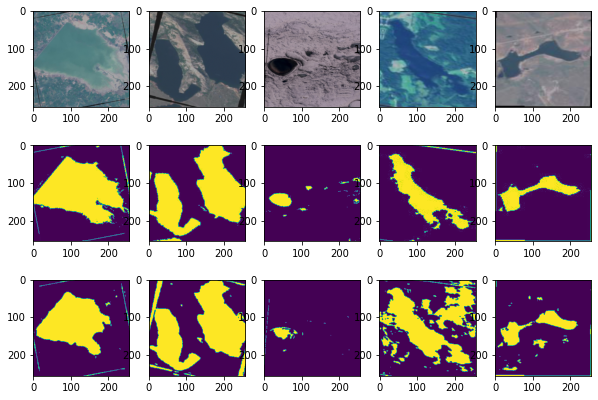

Epoch 34 - Train Loss 0.3548 - Val Loss 0.3611

----- Epoch 35 -----


100%|██████████| 18/18 [00:09<00:00,  1.89it/s]


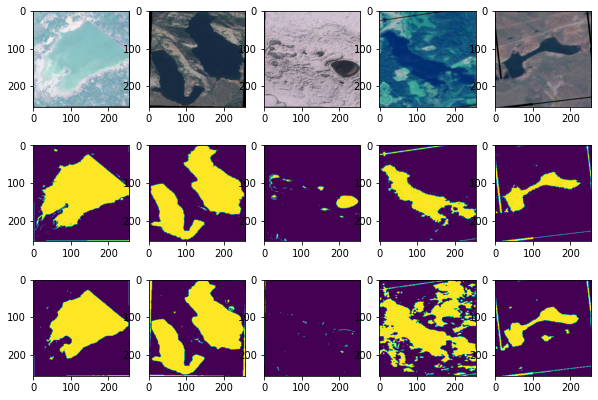

Epoch 35 - Train Loss 0.3606 - Val Loss 0.3429

----- Epoch 36 -----


100%|██████████| 18/18 [00:09<00:00,  1.91it/s]


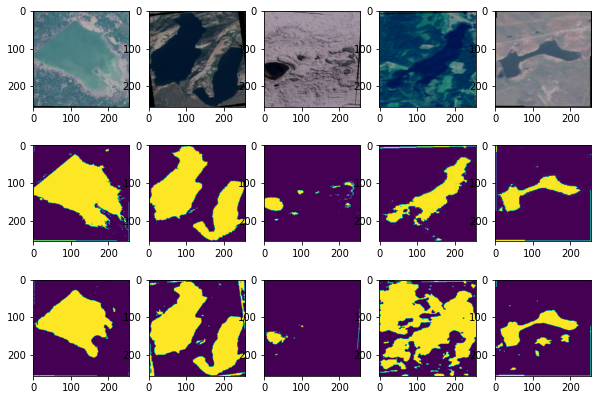

Epoch 36 - Train Loss 0.3562 - Val Loss 0.3542

----- Epoch 37 -----


100%|██████████| 18/18 [00:09<00:00,  1.97it/s]


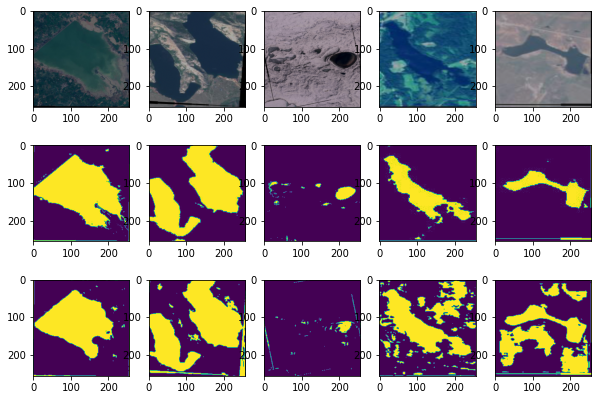

Epoch 37 - Train Loss 0.3544 - Val Loss 0.3408

----- Epoch 38 -----


100%|██████████| 18/18 [00:09<00:00,  1.95it/s]


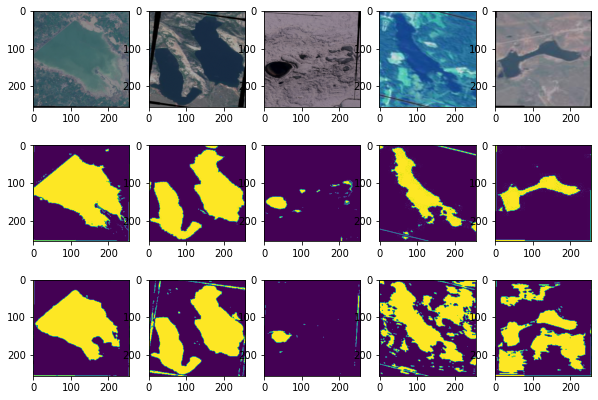

Epoch 38 - Train Loss 0.3539 - Val Loss 0.3471

----- Epoch 39 -----


100%|██████████| 18/18 [00:08<00:00,  2.06it/s]


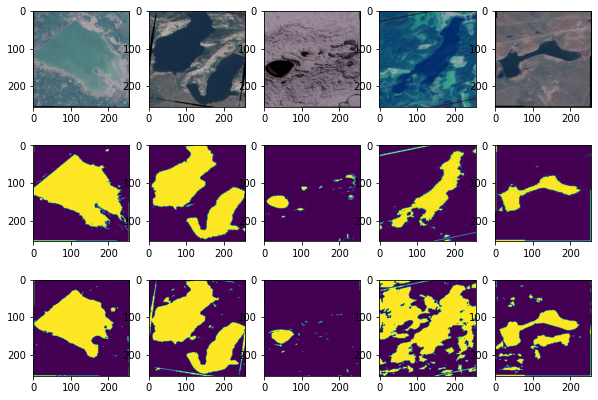

Epoch 39 - Train Loss 0.3520 - Val Loss 0.3585

----- Epoch 40 -----


100%|██████████| 18/18 [00:08<00:00,  2.19it/s]


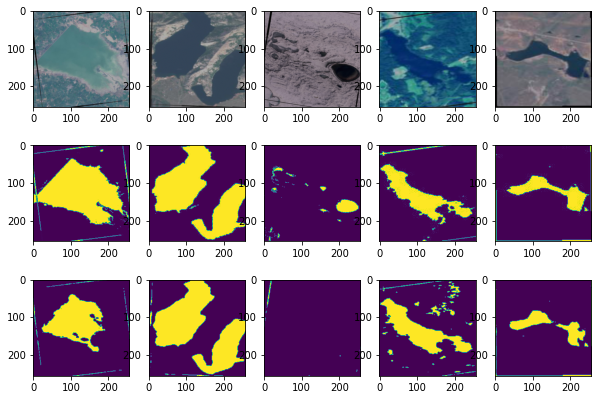

Epoch 40 - Train Loss 0.3477 - Val Loss 0.3840



In [17]:
train_losses = []
valid_losses = []

best_dict = None
best_loss = np.inf

for ep in range(EPOCHS):
    print('-'*5 + f" Epoch {ep+1} " + '-'*5)

    tr_loss = train_fn(train_loader, model, criterion, optimizer)
    val_loss = valid_fn(valid_loader, model, criterion)

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pt')

    train_losses.append(tr_loss)
    valid_losses.append(val_loss)
    
    visualize(model, valid_loader)
    
    print(f"Epoch {ep + 1} - Train Loss {tr_loss:.4f} - Val Loss {val_loss:.4f}\n")

### <b>TRAINING AND VALIDATION LOSS CURVE</b>

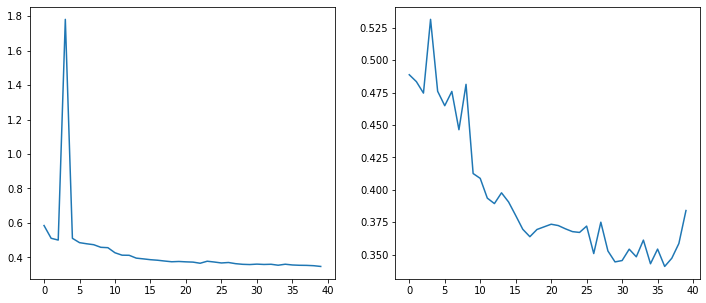

In [18]:
model.load_state_dict(torch.load('./best_model.pt'))
fig = plt.figure(figsize = (12, 5))
fig.add_subplot(1,2,1)
plt.plot(train_losses)
fig.add_subplot(1,2,2)
plt.plot(valid_losses)

### <b>FINAL RESULTS BY TRAINED MODEL</b>

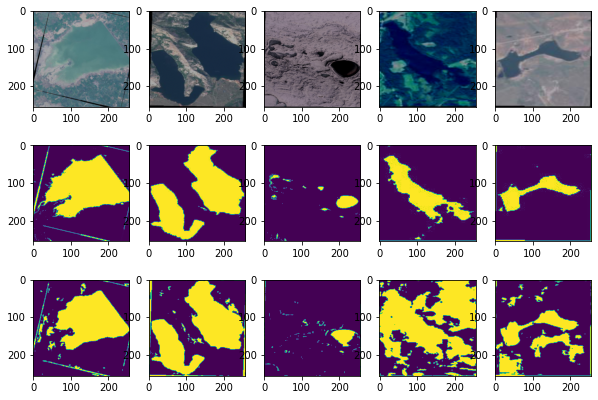

In [19]:
visualize(model, valid_loader)